# Exploring simulated data files from LDMX

In this notebook we will explore the data files that we will use in our project. We use the coffea, awkward1 and matplotlib python libraries (best to install them locally).

Data files are located here:
https://www.dropbox.com/sh/ui5d0rl6zcpm1un/AAA7MUJvuai9t52yFoPHJ9uba?dl=0

These files contain a collection of Sim-Particles from a PN generation process. PN here stands for photonuclear and means that a photon-nuclei interaction was produced. We generate this interaction in our simulation in the target region.

It is a good idea to get started with some of the events in the `kaon_pn_4GeV_Jul27_ntuple` directory:
https://www.dropbox.com/s/8ml0eyfkz75imig/kaon_pn_4GeV_Jun30_ntuple.zip?dl=0

and download them into the `data` directory.

Other notebooks for reference: https://github.com/chloefnal/ldmx-helpers/tree/main/notebooks

In [1]:
from coffea import hist
import math
import os
import uproot
import awkward as ak

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

Let's first open of these files with `uproot`. We can print the keys of this file and explore one of the variables.

In [2]:
with uproot.open("data/kaon_pn_4GeV_Jul27_ntuple/pn_kaonfilter_1M_events_r0416_b403901.root") as file:
    print(file["Events"].keys())
    print(file["Events"]["Sim_PNParticle_pdgID"].array())

['n_Sim_PNParticle', 'Sim_PNParticle_pdgID', 'Sim_PNParticle_trkID', 'Sim_PNParticle_mass', 'Sim_PNParticle_e', 'Sim_PNParticle_kine', 'Sim_PNParticle_vx', 'Sim_PNParticle_vy', 'Sim_PNParticle_vz', 'Sim_PNParticle_px', 'Sim_PNParticle_py', 'Sim_PNParticle_pz', 'Sim_PNParticle_electrone', 'Sim_PNParticle_dau1_e', 'Sim_PNParticle_dau1_px', 'Sim_PNParticle_dau1_py', 'Sim_PNParticle_dau1_pz', 'Sim_PNParticle_dau1_z', 'Sim_PNParticle_dau1_pdgID', 'Sim_PNParticle_dau1_mompdgID', 'Sim_PNParticle_dau1_mome', 'Sim_PNParticle_dau1_momdecay', 'Sim_PNParticle_dau1_electrone', 'Sim_PNParticle_dau2_e', 'Sim_PNParticle_dau2_px', 'Sim_PNParticle_dau2_py', 'Sim_PNParticle_dau2_pz', 'Sim_PNParticle_dau2_z', 'Sim_PNParticle_dau2_pdgID', 'Sim_PNParticle_dau2_mompdgID', 'Sim_PNParticle_dau2_mome', 'Sim_PNParticle_dau2_momdecay', 'Sim_PNParticle_dau2_electrone', 'Target_Proton_pz', 'Target_Neutron_pz', 'Target_ChPion_pz', 'Target_Lambda_pz', 'Target_Proton_t', 'Target_Neutron_t', 'Target_ChPion_t', 'Target_

Now let's define a class so that we can explore this data better. This class is usually defined in a `data.py` script but let's explore it first here. 
One annoying thing is that once you have run the generator cell you need to restart the kernel if you want to re-generate it (Generators in python can't be rewound). So let's run the same line again.

In [3]:
# Let's define attributes
SimParticle_attrs = ['pdgID','trkID','px','py','pz','e','mass','vx','vy','vz','electrone']
SimParticle_dau_attrs = ['pdgID','z','px','py','pz','e','mompdgID','mome','momdecay', 'electrone']

branches = {
    "Sim_PNParticle": SimParticle_attrs,
    "Sim_PNParticle_dau1": SimParticle_dau_attrs,
    "Sim_PNParticle_dau2": SimParticle_dau_attrs,
}

def getData(fnames="", treeName="Events", chunks=False):
    branchlist = []
    for collection, attrs in branches.items():
        branchlist += [collection+"_"+attr for attr in attrs]
    if chunks: ldmx_dict = uproot.iterate(fnames+":"+treeName, branchlist)
    else: ldmx_dict = uproot.lazy(fnames+":"+treeName, branchlist)
    return ldmx_dict

def repackage(ldmx_dict):
    evt_dict={}
    for collection in branches:    
        coll_dict={}
        for attr in branches[collection]:
            bname = "{}_{}".format(collection, attr)
            coll_dict[attr] = ldmx_dict[bname]
        evt_dict[collection] = ak.zip(coll_dict)        
    ldmx_events = ak.zip(evt_dict, depth_limit=1)
    return ldmx_events

Now we can use the class to get a dictionary with a `generator` that will loop over all the files in that directory. Be careful becuase once you loop over this generator object you can't access it again and will need to restart the noteboook.

In [4]:
ldmx_dict = getData(chunks=True, fnames="/Users/cmantill/LDMX/ldmx-helpers/notebooks/data/kaon_pn_4GeV_Jul27_ntuple/pn_kaonfilter_1M_events_r0416_b403901.root")

In [5]:
print(ldmx_dict)

<generator object iterate at 0x7f7fe920bba0>


Now let's define a couple of functions that can help us add more variables to our dictionary

In [6]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [7]:
def pz_smear(pz):
    pz_array = []
    for part in pz:
        for element in part:
            if element <= 50:
                pz_perc = random.gauss(1,0.0404);
            elif element <= 100: 
                pz_perc = random.gauss(1,0.0410);
            elif element <= 250: 
                pz_perc = random.gauss(1,0.0415);
            elif element <= 500: 
                pz_perc = random.gauss(1,0.0420);
            elif element <= 1000: 
                pz_perc = random.gauss(1,0.0435);
            elif element <= 2000:  
                pz_perc = random.gauss(1,0.0477);
            elif element <= 3000:  
                pz_perc = random.gauss(1,0.0523);
            elif element <= 4000:  
                pz_perc = random.gauss(1,0.0573);            
            else:    
                pz_perc = random.gauss(1,0.06);
            pz_array=np.append(pz_array, [pz_perc])
    return (pz_array)

def px_smear(p):
    px_array = []
    for part in p:
        for element in part:
            if element <= 100:
                px_uncer = random.gauss(0,3.00);
            elif element <= 400: 
                px_uncer = random.gauss(0,3.20);
            elif element <= 500: 
                px_uncer = random.gauss(0,3.20);
            elif element <= 1000: 
                px_uncer = random.gauss(0,3.40);
            elif element <= 1300: 
                px_uncer = random.gauss(0,3.50);
            elif element <= 2000:  
                px_uncer = random.gauss(0,3.85);           
            else:    
                px_uncer = random.gauss(0,3.85);
            px_array=np.append(px_array, [px_uncer])
    return (px_array)

def py_smear(p):
    py_array = []
    for part in p:
        for element in part:
            if element <= 100:
                py_uncer = random.gauss(0,3.75);
            elif element <= 350: 
                py_uncer = random.gauss(0,3.80);
            elif element <= 500: 
                py_uncer = random.gauss(0,4.20);
            elif element <= 1000: 
                py_uncer = random.gauss(0,4.80);
            elif element <= 1200: 
                py_uncer = random.gauss(0,4.98);
            elif element <= 2000:  
                py_uncer = random.gauss(0,3.85);           
            else:    
                py_uncer = random.gauss(0,5.50);
            py_array=np.append(py_array, [py_uncer])
    return (py_array)

For example, the function get vector allows us to get a 4-vector definition of our particle using this functionality: https://coffeateam.github.io/coffea/modules/coffea.nanoevents.methods.vector.html

In [8]:
for i,ev in enumerate(ldmx_dict):
    if i==0:
        ldmx_events = repackage(ev)
        
        # let's get all the attributes from daughter 1
        sim_particle_dau1 = ldmx_events['Sim_PNParticle_dau1']
        
        # now let's get a vector
        dau1 = get_vector(sim_particle_dau1)
        
        # and the attributes of this vector
        print(dau1.pz)
        
        # we can also implement a mask for example requiring that the daughter is coming from a pi+pi- decay (that is decay 2 in this ntuple)
        decay_num_mask = sim_particle_dau1.momdecay == 2
        
        # and requiring that the daughter's pdgID is that of the pion (211)
        decay1_mask = abs(sim_particle_dau1.pdgID) == 211
        
        # all of these masks are a list of booleans
        print(decay_num_mask,decay1_mask)
        
        # now we can apply the mask
        print(dau1.pz[decay_num_mask])
        
        break
  

[[0, 0, 0, 0, -73.4, 0, -20.1, 0, 104, 0, 0, ... 0, 0], [322, 162, 0, 0, 0, 0, 0]]
[[False, False, False, False, False, False, ... False, False, False, False, False]] [[False, False, False, False, False, False, ... False, False, False, False, False]]
[[], [888], [], [], [], [], [], [], ... [], [], [], [32.6], [-30.3], [300], [322]]


Now let's define some coffea histograms where we can store our information. Each hist.Bin defines a new axis of the histogram.

In [9]:
hists = {}

hists["rec"] = hist.Hist("Sim PN Particle",
                         hist.Bin("e", r"Kinetic Energy [MeV]", 7, 0, 3000),
                        )

In [10]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    sim_particle = ldmx_events['Sim_PNParticle']
    sim_particle_dau1 = ldmx_events['Sim_PNParticle_dau1']
    sim_particle_dau2 = ldmx_events['Sim_PNParticle_dau2']
    
    pi_mass = 139.57039
    kaon_mass = 493.677
    
    kshort_mask = sim_particle.pdgID == 310
    klong_mask  = sim_particle.pdgID == 130
    kplus_mask  = sim_particle.pdgID == 321
    kminus_mask = sim_particle.pdgID == -321
    kaon_mask = kshort_mask | klong_mask | kplus_mask | kminus_mask
    n_kaons = ak.sum(kaon_mask, axis = 1)
    n_kaon_mask = n_kaons == 1
    
    decay_num_mask = sim_particle_dau2.momdecay == 2
    decay2_mask = abs(sim_particle_dau2.pdgID) == 211
    decay_mask = decay_num_mask & decay2_mask
    total_mask = decay_mask & n_kaon_mask
    
    dau1 = get_vector(sim_particle_dau1[total_mask])
    dau2 = get_vector(sim_particle_dau2[total_mask])
    dausum = (dau1 + dau2)

    n_px1 = px_smear(dau1.p)+flat(dau1.px)
    n_px2 = px_smear(dau2.p)+flat(dau2.px)
    n_py1 = py_smear(dau1.p)+flat(dau1.py)
    n_py2 = py_smear(dau2.p)+flat(dau2.py)
    n_pz1 = pz_smear(dau1.pz)*flat(dau1.pz)
    n_pz2 = pz_smear(dau2.pz)*flat(dau2.pz)
    n_psq1= n_px1**2+n_py1**2+n_pz1**2
    n_psq2= n_px2**2+n_py2**2+n_pz2**2
    n_e1 = (np.sqrt(n_psq1+pi_mass**2))
    n_e2 = (np.sqrt(n_psq2+pi_mass**2))
    
    # you can also use other types of vector
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)
    dau1_smear =  ak.zip({"x": n_px1,
                    "y": n_py1,
                    "z": n_pz1,
                    "t": n_e1,
                    },
                    with_name="LorentzVector")
    dau2_smear =  ak.zip({"x": n_px2,
                    "y": n_py2,
                    "z": n_pz2,
                    "t": n_e2,
                    },
                    with_name="LorentzVector")
    dausum_smear = dau1_smear + dau2_smear

    hists["rec"].fill(e = flat(dausum_smear.t)-kaon_mass)  


In [11]:
ldmx_dict_all = getData(chunks=True, fnames="/Users/cmantill/LDMX/ldmx-helpers/notebooks/data/kaon_pn_4GeV_Jul27_ntuple/*.root")


In [12]:
nchunk = 0
for chunk in ldmx_dict_all:
    nchunk += 1
    print('process',nchunk)
    ProcessChunk(chunk, hists)

process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
process 15
process 16
process 17
process 18
process 19
process 20
process 21
process 22
process 23
process 24
process 25
process 26
process 27
process 28
process 29
process 30
process 31
process 32
process 33
process 34
process 35
process 36
process 37
process 38
process 39
process 40
process 41
process 42
process 43
process 44
process 45
process 46
process 47
process 48
process 49
process 50
process 51
process 52
process 53
process 54
process 55
process 56
process 57
process 58
process 59
process 60
process 61
process 62
process 63
process 64
process 65
process 66
process 67
process 68
process 69
process 70
process 71
process 72
process 73
process 74
process 75
process 76
process 77
process 78
process 79
process 80
process 81
process 82
process 83
process 84
process 85
process 86
process 87
process 88
process 89
process 90
process 91
process 

<Hist (e) instance at 0x7f7ff95bcf40>


Text(1, 0, '$K_S$ Rec Kinetic Energy [MeV]')

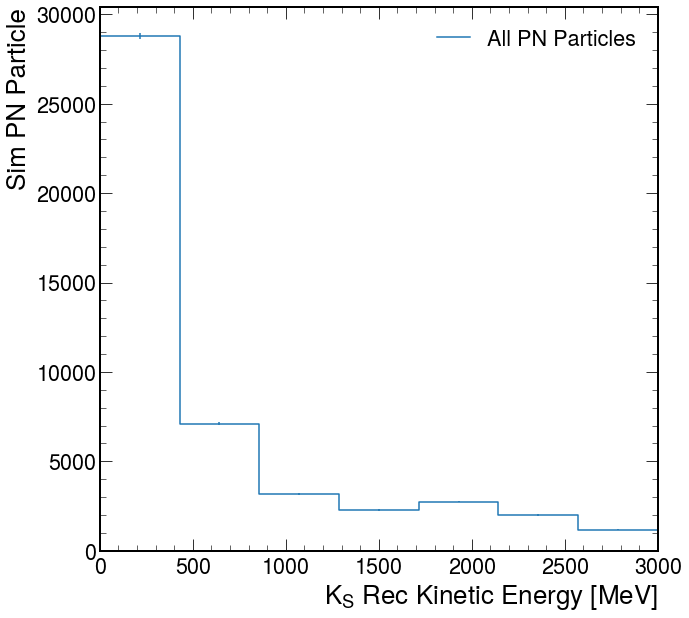

In [13]:
print(hists["rec"])
fig, ax = plt.subplots()
hist.plot1d(hists["rec"],ax=ax,clear=False);
leg = ax.legend([r'All PN Particles'])
ax.set_xlabel(r'$K_S$ Rec Kinetic Energy [MeV]')